In [1]:
from pycigar.envs import Env
import yaml

import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

class FooEnv(Env):
    @property
    def observation_space(self):
        return Box(low=-float('inf'), high=float('inf'),
                   shape=(5,), dtype=np.float64)

    @property
    def action_space(self):
        return Box(low=0.5, high=1.5, shape=(5,), dtype=np.float64)

    def step(self, rl_actions=None, randomize_rl_update=None):
        """See parent class.
        """

        for _ in range(self.sim_params['env_config']["sims_per_step"]):
            self.env_time += 1
            
            # perform action update for PV inverter device
            if len(self.k.device.group_controllers.keys()) > 0:
                control_setting = []
                devices = []
                for group_controller_name, group_controller in self.k.device.group_controllers.items():
                    action = group_controller.get_action(self)
                    if isinstance(action, tuple):
                        if isinstance(group_controller.device_id, str):
                            devices.extend([group_controller.device_id])
                            control_setting.extend((action,))
                        else:
                            devices.extend(group_controller.device_id)
                            control_setting.extend((action,)*len(group_controller.device_id))
                    elif isinstance(action, dict):
                        devices.extend(action.keys())
                        control_setting.extend(action.values())
                self.k.device.apply_control(devices, control_setting)

            # perform action update for PV inverter device
            if len(self.k.device.get_local_device_ids()) > 0:
                control_setting = []
                for device_id in self.k.device.get_local_device_ids():
                    action = self.k.device.get_controller(device_id).get_action(self)
                    control_setting.append(action)
                self.k.device.apply_control(self.k.device.get_local_device_ids(), control_setting)


            self.additional_command()

            if self.k.time <= self.k.t:
                self.k.update(reset=False)

                # check whether the simulator sucessfully solved the powerflow
                converged = self.k.simulation.check_converged()
                if not converged:
                    break

            if self.k.time >= self.k.t:
                break

        # the episode will be finished if it is not converged.
        done = not converged or (self.k.time == self.k.t)
        obs = self.get_state()
        infos = {}
        reward = self.compute_reward(rl_actions)

        return obs, reward, done, infos

    def get_state(self):
        return [0, 0, 0, 0, 0]

    def compute_reward(self, rl_actions, **kwargs):
        return 0

stream = open("./IEEE_13_Node/pycigar_config_ieee_13_dist_storage.yaml", "r")
sim_params = yaml.safe_load(stream)

print('Simulation Complete')

Simulation Complete


In [2]:
from pycigar.utils.registry import register_devcon
from pycigar.controllers.battery_storage_controller import BatteryStorageController
from pycigar.devices.battery_storage_device import BatteryStorageDevice
from pycigar.devices.battery_storage_device_advanced import BatteryStorageDeviceAdvanced

# from pycigar.controllers.battery_peak_shaving_controller import BatteryPeakShavingController
from pycigar.controllers.battery_peak_shaving_controller_dist import BatteryPeakShavingControllerDist

# register_devcon('battery_storage_controller', BatteryStorageController)
# register_devcon('battery_peak_shaving_controller', BatteryPeakShavingController)
register_devcon('battery_peak_shaving_controller_dist', BatteryPeakShavingControllerDist)
register_devcon('battery_storage_device_advanced', BatteryStorageDeviceAdvanced)


'battery_storage_device_advanced'

In [3]:
import pandas as pd
network_data_directory_path = sim_params['scenario_config']['network_data_directory']
profile = pd.read_csv(network_data_directory_path)

print(profile)

              671        634a        634b        634c         645        646  \
0      153.498095  123.820921  397.393281   74.998196  101.058024  14.982539   
1      153.888862  123.437081  398.155538   75.129048  100.717811  14.985800   
2      154.296907  123.628316  397.345749   75.112356  100.755853  14.967991   
3      154.583609  123.880350  396.446687   75.055569  100.504302  14.987306   
4      154.517872  123.923076  395.427583   74.826989  100.676553  15.001729   
...           ...         ...         ...         ...         ...        ...   
14395  125.540607  159.842405  312.939251  100.556106   75.341281  18.771625   
14396  125.216126  159.906007  313.029138  100.576919   75.459595  18.718710   
14397  124.977787  160.244207  313.226022  100.416297   75.399640  18.722321   
14398  124.940089  160.203535  313.548161  100.512246   75.364451  18.703354   
14399  125.051054  160.365705  313.390794  100.619762   75.238972  18.723441   

             692       675a       675b 

In [4]:
env = FooEnv(sim_params)
env.reset()
done = False
while not done:
    _, _, done, _ = env.step()
    # if env.k.time % 60 == 0:
    #     print('Time: ' + str(env.k.time))
    # if env.k.time >= 55:
    #     done = True
    
print('Simulation Complete')

psc_bsd_671a
psc_bsd_671b
psc_bsd_671c
bsd_671a
144000000.0
500.0
bsd_671b
126000000.0
500.0
bsd_671c
108000000.0
500.0
bsd_671a
144000000.0
500.0
bsd_671b
126000000.0
500.0
bsd_671c
108000000.0
500.0
Time: 51
Initialize: psc_bsd_671a
Time: 51
Initialize: psc_bsd_671b
Time: 51
Initialize: psc_bsd_671c
Simulation Complete


In [5]:
from pycigar.utils.logging import logger

Logger = logger()

Logger.log_dict.keys()

dict_keys(['psc_bsd_671a', 'psc_bsd_671b', 'psc_bsd_671c', 'pv_671', 'pv_634a', 'pv_634b', 'pv_634c', 'pv_645', 'pv_646', 'pv_692', 'pv_675a', 'pv_675b', 'pv_675c', 'pv_611', 'pv_652', 'pv_670a', 'pv_670b', 'pv_670c', 'bsd_671a', 'bsd_671b', 'bsd_671c', '671', '634a', '634b', '634c', '645', '646', '692', '675a', '675b', '675c', '611', '652', '670a', '670b', '670c', 'network'])

In [6]:
env.k.device.devices

{'pv_671': {'device': <pycigar.devices.pv_inverter_device.PVDevice at 0x7f0fa5f6fcd0>,
  'controller': <pycigar.controllers.fixed_controller.FixedController at 0x7f0fa5f6f950>,
  'node_id': '671'},
 'pv_634a': {'device': <pycigar.devices.pv_inverter_device.PVDevice at 0x7f0fa5f6f6d0>,
  'controller': <pycigar.controllers.fixed_controller.FixedController at 0x7f0fa5f5e6d0>,
  'node_id': '634a'},
 'pv_634b': {'device': <pycigar.devices.pv_inverter_device.PVDevice at 0x7f0fa5f6f590>,
  'controller': <pycigar.controllers.fixed_controller.FixedController at 0x7f0fa5f6f450>,
  'node_id': '634b'},
 'pv_634c': {'device': <pycigar.devices.pv_inverter_device.PVDevice at 0x7f0fa5f6fed0>,
  'controller': <pycigar.controllers.fixed_controller.FixedController at 0x7f0fa5f6fd90>,
  'node_id': '634c'},
 'pv_645': {'device': <pycigar.devices.pv_inverter_device.PVDevice at 0x7f0fa5f6f850>,
  'controller': <pycigar.controllers.fixed_controller.FixedController at 0x7f0fa5f6ff50>,
  'node_id': '645'},
 'pv

In [7]:

Logger.log_dict.keys()

# Logger.log_dict['611'].keys()


dict_keys(['psc_bsd_671a', 'psc_bsd_671b', 'psc_bsd_671c', 'pv_671', 'pv_634a', 'pv_634b', 'pv_634c', 'pv_645', 'pv_646', 'pv_692', 'pv_675a', 'pv_675b', 'pv_675c', 'pv_611', 'pv_652', 'pv_670a', 'pv_670b', 'pv_670c', 'bsd_671a', 'bsd_671b', 'bsd_671c', '671', '634a', '634b', '634c', '645', '646', '692', '675a', '675b', '675c', '611', '652', '670a', '670b', '670c', 'network'])

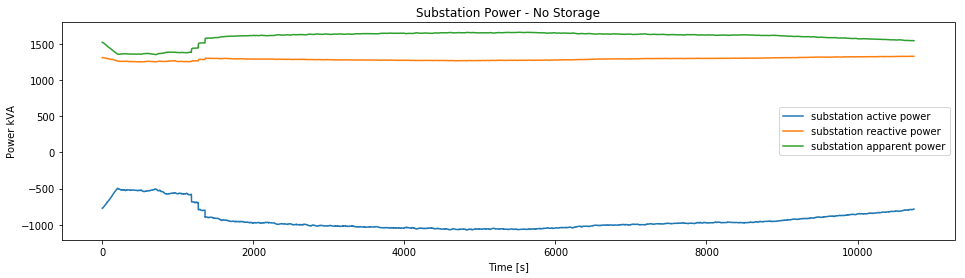

In [8]:

fig1 = plt.figure(figsize = [16, 4])
plt.plot(-np.asarray(Logger.log_dict['network']['substation_power'])[:,0],label="substation active power")
plt.plot(-np.asarray(Logger.log_dict['network']['substation_power'])[:,1],label="substation reactive power")
plt.plot((np.asarray(Logger.log_dict['network']['substation_power'])[:,0]**2 + np.asarray(Logger.log_dict['network']['substation_power'])[:,1]**2)**0.5,label="substation apparent power")
plt.title('Substation Power - No Storage')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.legend()

plt.show()


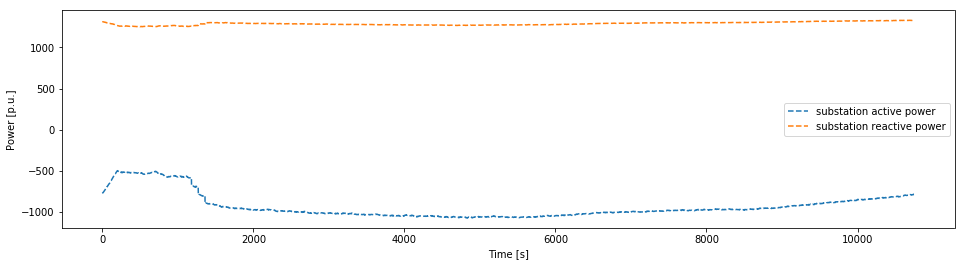

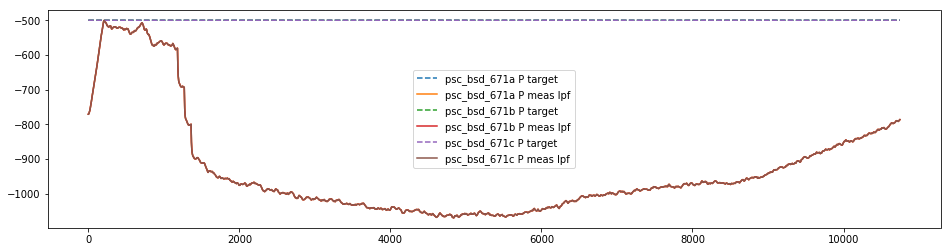

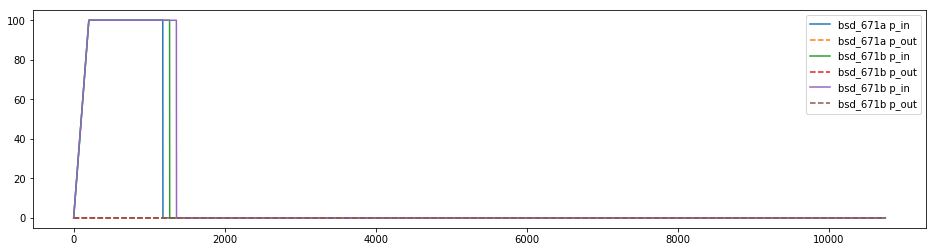

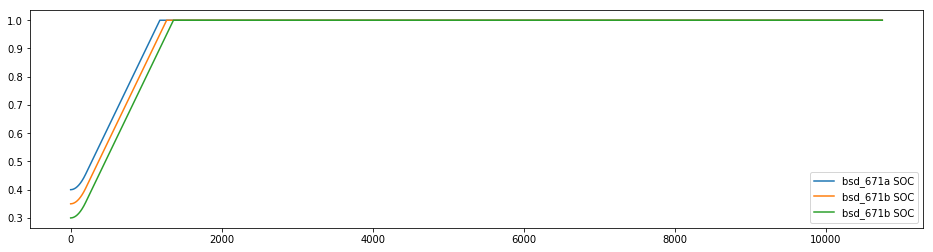

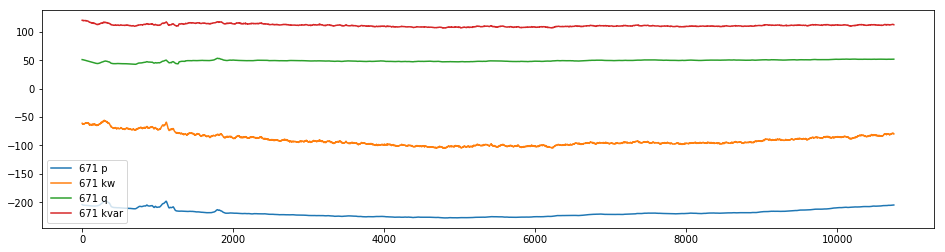

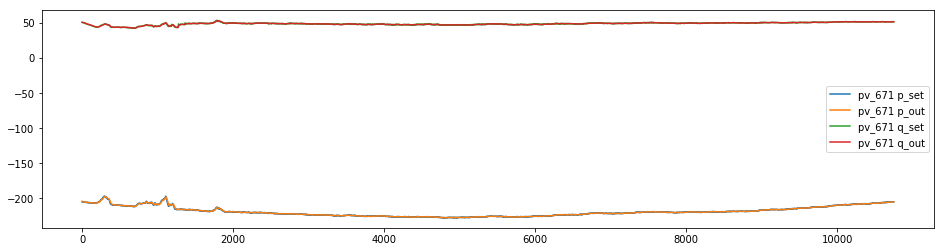

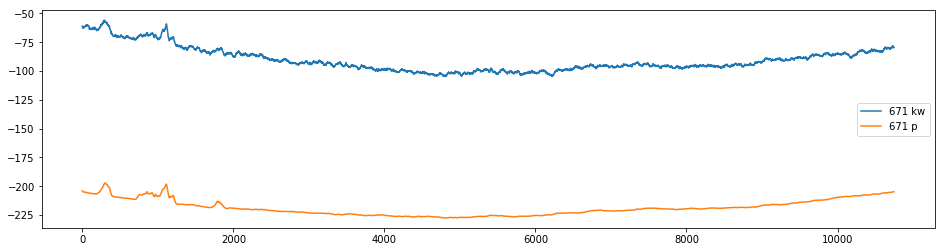

In [9]:
Logger.log_dict['bsd_671a'].keys()
# Logger.log_dict['bsd_1']['SOC']


# fig1 = plt.figure(figsize = [16, 4])
# plt.plot(Logger.log_dict['network']['substation_top_voltage'],'--',label="bsd_1_psc P target")
# plt.plot(Logger.log_dict['network']['substation_bottom_voltage'],label="bsd_1_psc P meas lpf")
# # plt.plot(Logger.log_dict['bsd_2_psc']['measured_active_power'],label="P meas")
# # plt.plot(Logger.log_dict['bsd_2_psc']['measured_active_power_lpf'],label="bsd_2_psc P meas lpf")
# # plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.ylabel('Voltage [p.u.]')
# plt.legend()

fig1 = plt.figure(figsize = [16, 4])
plt.plot(-np.asarray(Logger.log_dict['network']['substation_power'])[:,0],'--',label="substation active power")
plt.plot(-np.asarray(Logger.log_dict['network']['substation_power'])[:,1],'--',label="substation reactive power")
# plt.plot(Logger.log_dict['bsd_2_psc']['measured_active_power'],label="P meas")
# plt.plot(Logger.log_dict['bsd_2_psc']['measured_active_power_lpf'],label="bsd_2_psc P meas lpf")
# plt.title('Battery State of Charge - External Control')
plt.xlabel('Time [s]')
plt.ylabel('Power [p.u.]')
plt.legend()



fig1 = plt.figure(figsize = [16, 4])
plt.plot(Logger.log_dict['psc_bsd_671a']['p_target'],'--',label="psc_bsd_671a P target")
plt.plot(Logger.log_dict['psc_bsd_671a']['measured_active_power_lpf'],label="psc_bsd_671a P meas lpf")
plt.plot(Logger.log_dict['psc_bsd_671b']['p_target'],'--',label="psc_bsd_671b P target")
plt.plot(Logger.log_dict['psc_bsd_671b']['measured_active_power_lpf'],label="psc_bsd_671b P meas lpf")
plt.plot(Logger.log_dict['psc_bsd_671c']['p_target'],'--',label="psc_bsd_671c P target")
plt.plot(Logger.log_dict['psc_bsd_671c']['measured_active_power_lpf'],label="psc_bsd_671c P meas lpf")
# plt.plot(Logger.log_dict['bsd_2_psc']['measured_active_power'],label="P meas")
# plt.plot(Logger.log_dict['bsd_2_psc']['measured_active_power_lpf'],label="bsd_2_psc P meas lpf")
# plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.xlabel('SOC')
plt.legend()


# fig1 = plt.figure(figsize = [16, 4])
# plt.plot(Logger.log_dict['bsd_1_psc']['p_set'],label="bsd_1_psc p_set")
# plt.plot(Logger.log_dict['bsd_2_psc']['p_set'],label="bsd_2_psc p_set")
# plt.plot(Logger.log_dict['bsd_3_psc']['p_set'],label="bsd_3_psc p_set")
# # plt.plot(Logger.log_dict['bsd_1_psc']['measured_active_power_lpf'],label="P meas lpf")
# # plt.title('Battery State of Charge - External Control')
# # plt.xlabel('Time [s]')
# # plt.xlabel('SOC')
# plt.legend()

fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.array(Logger.log_dict['bsd_671a']['p_in'])/1e3,label="bsd_671a p_in")
plt.plot(np.array(Logger.log_dict['bsd_671a']['p_out'])/1e3,'--',label="bsd_671a p_out")
plt.plot(np.array(Logger.log_dict['bsd_671b']['p_in'])/1e3,label="bsd_671b p_in")
plt.plot(np.array(Logger.log_dict['bsd_671b']['p_out'])/1e3,'--',label="bsd_671b p_out")
plt.plot(np.array(Logger.log_dict['bsd_671c']['p_in'])/1e3,label="bsd_671b p_in")
plt.plot(np.array(Logger.log_dict['bsd_671c']['p_out'])/1e3,'--',label="bsd_671b p_out")
plt.legend()

fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.array(Logger.log_dict['bsd_671a']['SOC']),label="bsd_671a SOC")
plt.plot(np.array(Logger.log_dict['bsd_671b']['SOC']),label="bsd_671b SOC")
plt.plot(np.array(Logger.log_dict['bsd_671c']['SOC']),label="bsd_671b SOC")
plt.legend()


# fig1 = plt.figure(figsize = [16, 4])
# plt.plot(Logger.log_dict['bsd_1']['SOC'],label="bsd_1 SOC")
# plt.plot(Logger.log_dict['bsd_2']['SOC'],label="bsd_2 SOC")
# plt.plot(Logger.log_dict['bsd_3']['SOC'],label="bsd_3 SOC")
# # plt.plot(Logger.log_dict['bsd_1_psc']['measured_active_power_lpf'],label="P meas lpf")
# # plt.title('Battery State of Charge - External Control')
# # plt.xlabel('Time [s]')
# # plt.xlabel('SOC')
# plt.legend()

fig1 = plt.figure(figsize = [16, 4])
plt.plot(Logger.log_dict['671']['p'],label="671 p")
plt.plot(Logger.log_dict['671']['kw'],label="671 kw")
plt.plot(Logger.log_dict['671']['q'],label="671 q")
plt.plot(Logger.log_dict['671']['kvar'],label="671 kvar")
# plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.xlabel('SOC')
plt.legend()

fig1 = plt.figure(figsize = [16, 4])
plt.plot(Logger.log_dict['pv_671']['p_set'],label="pv_671 p_set")
plt.plot(Logger.log_dict['pv_671']['p_out'],label="pv_671 p_out")
plt.plot(Logger.log_dict['pv_671']['q_set'],label="pv_671 q_set")
plt.plot(Logger.log_dict['pv_671']['q_out'],label="pv_671 q_out")
# plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.xlabel('SOC')
plt.legend()

fig1 = plt.figure(figsize = [16, 4])
plt.plot(Logger.log_dict['671']['kw'],label="671 kw")
plt.plot(Logger.log_dict['671']['p'],label="671 p")
# plt.plot(Logger.log_dict['pv_671']['p_out'],label="pv_671 p_out")
# plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.xlabel('SOC')
plt.legend()


plt.show()

# fig1.savefig('/home/michael/Desktop/temp/SOC.png')

In [10]:
print(Logger.log_dict['network']['substation_power'][0])

[  772.23878839 -1310.60794569]


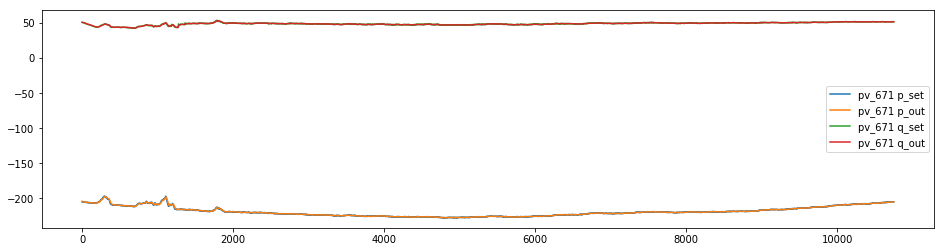

In [11]:
fig1 = plt.figure(figsize = [16, 4])
plt.plot(Logger.log_dict['pv_671']['p_set'],label="pv_671 p_set")
plt.plot(Logger.log_dict['pv_671']['p_out'],label="pv_671 p_out")
plt.plot(Logger.log_dict['pv_671']['q_set'],label="pv_671 q_set")
plt.plot(Logger.log_dict['pv_671']['q_out'],label="pv_671 q_out")
# plt.plot(Logger.log_dict['pv_671b']['SOC'],label="bsd_2 SOC")
# plt.plot(Logger.log_dict['pv_671c']['SOC'],label="bsd_3 SOC")
# plt.plot(Logger.log_dict['bsd_1_psc']['measured_active_power_lpf'],label="P meas lpf")
# plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.xlabel('SOC')
plt.legend()

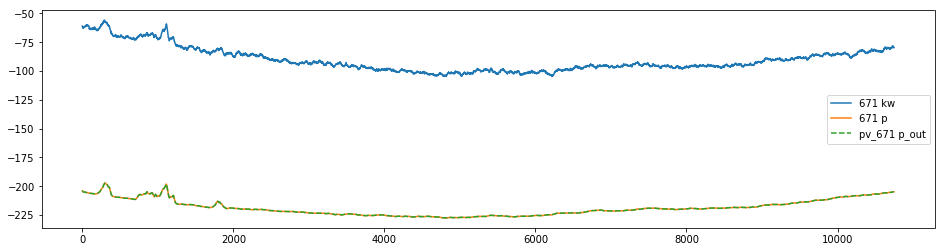

In [12]:
fig1 = plt.figure(figsize = [16, 4])
plt.plot(Logger.log_dict['671']['kw'],label="671 kw")
plt.plot(Logger.log_dict['671']['p'],label="671 p")
plt.plot(Logger.log_dict['pv_671']['p_out'],'--',label="pv_671 p_out")
# plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.xlabel('SOC')
plt.legend()